<a href="https://colab.research.google.com/github/vbvss199/colab_notebooks/blob/main/Copy_of_Part2_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data Processing
## Step 1: Data Processing
1. Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
2. Estimate mean and variance from the training data for normalization.
3. Create "transforms" for training and test for normalization and data augmentation.
4. Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
5. Partition the training dataset further into training and validation
6. Use dataloder to partition and generate minibatches.
7. Visualize input and output for two sample images.

In [ ]:
!pip install Pillow
!pip install onnxruntime

import pandas as pd
import PIL
import sklearn
import torch
import torchvision
import torch.onnx
import onnxruntime

from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.2 MB/s eta 0:00:00


###1. Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
###2. Estimate mean and variance from the training data for normalization.

In [ ]:
!pip install kaggle
!kaggle datasets download -d nitishabharathi/scene-classification
import zipfile

with zipfile.ZipFile('scene-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('scene-classification')



Progress report #65 completed, sleeping for 0.2 minutes
Dataset URL: https://www.kaggle.com/datasets/nitishabharathi/scene-classification
License(s): CC0-1.0
scene-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Progress report #28 completed, sleeping for 0.2 minutes
Progress report #66 completed, sleeping for 0.2 minutes


In [ ]:
from pathlib import Path
basePath = '/content/scene-classification/train-scene classification/'
resultPath = '/content/result/'
# adding a folder on kaggle to save models
Path(resultPath).mkdir(exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataPath = basePath + 'train/'
modelPath = resultPath + 'model.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###3. Create "transforms" for training and test for normalization and data augmentation.

In [ ]:
# getting the best weights for the selected model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# extract appropriate transformations to be applied to images
auto_transforms = weights.transforms()
# loading the pre-trained convolutional network efficientnet_b0 and changing the classifier to suit the task conditions (6 categories)
model = torchvision.models.efficientnet_b0(weights=weights)
model.classifier[1] = torch.nn.Linear(1280, 6)

Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=stopped)> (task=cf5f5b524fb44ea19aaa878b13eaa3cf, name=efficientnet_b0_rwightman-7f5810bc, model=cc6a0057350443059aa645b75f3037a1, type=input)


###4. Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self,index):
        x = Image.open(dataPath + self.dataframe.iloc[index,0])
        x = self.transform(x)
        y = self.dataframe.iloc[index,1]
        return x,y

    def __len__(self):
        return self.dataframe.shape[0]

###5. Partition the training dataset further into training and validation

In [ ]:
# read file with image names and labels
df = pd.read_csv(basePath + 'train.csv')
# splitting the data into training and testing parts
Train, Validation = train_test_split(df, test_size=0.2, shuffle=True, random_state=5)
df.head()
print("Training set size:", len(Train))
print("Validation set size:", len(Validation))
df.head()

Training set size: 13627
Validation set size: 3407


,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


###6. Use dataloder to partition and generate minibatches.

In [ ]:
# split samples into batches of 64 for upcoming "mini-batch" passes
batch_size = 64
train_set = CustomDataset(Train, transform=auto_transforms)
val_set = CustomDataset(Validation, transform=auto_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

print('Training set: {}, Validation set: {}'.format(Train.shape[0], Validation.shape[0]))

Training set: 13627, Validation set: 3407


###7. Visualize input and output for two sample images.

Progress report #30 completed, sleeping for 0.2 minutes


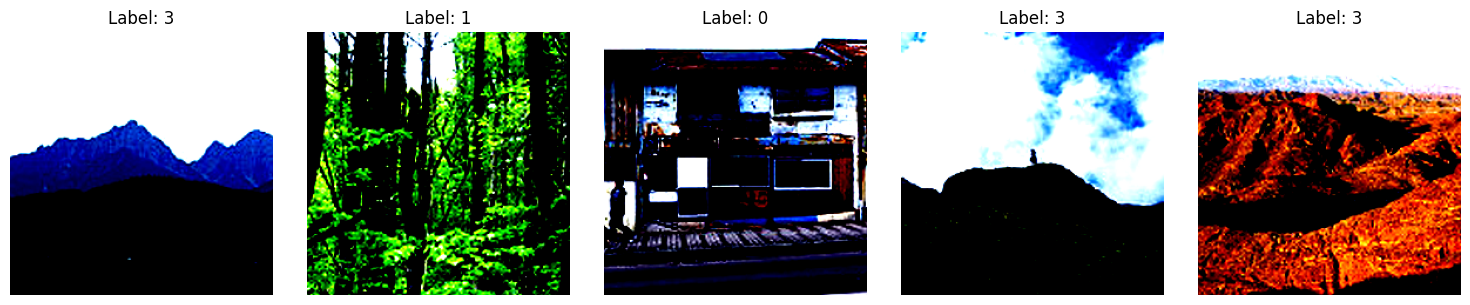

In [ ]:
import matplotlib.pyplot as plt

# Get the batch of examples
examples = next(iter(train_loader))

# examples[0] contains the images, examples[1] contains the labels
images, labels = examples

# Set up the plot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Loop through the first 5 images and display them
for i in range(5):
    img = images[i]
    axes[i].imshow(img.permute(1, 2, 0))  # Permute to (height, width, channels) for display
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()


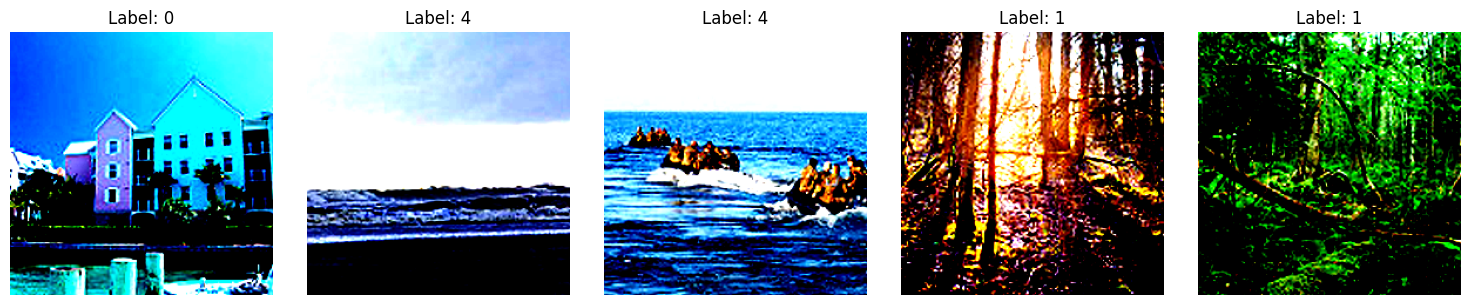

In [ ]:
import matplotlib.pyplot as plt

# Get the batch of examples
examples = next(iter(val_loader))

# examples[0] contains the images, examples[1] contains the labels
images, labels = examples

# Set up the plot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Loop through the first 5 images and display them
for i in range(5):
    img = images[i]
    axes[i].imshow(img.permute(1, 2, 0))  # Permute to (height, width, channels) for display
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()


## Step 2: initial network
###Step 1 steps are followed again here and re written the transformations and Customdtaset class as well
1. Create a convolutional neural network. Make the hyper-parameters that you want to tune (e.g., number of layers) dynamic so that you can change them without altering the code. You can choose additional hyperparameters but the followings must be considered.
   1. Number of filters
   2. Number of layers
   3. learning rate
   4. Optimization algorithm specific hyper-paramters, e.g., momentum, for SGD.
   5. weight decay.
3.Select two images. Pick a configuation of NN and hyperparamters and train to overfit the samples, i.e., the accuracy will be 100%. If the network does not overfit, try differnt hyperparamter configuration, e.g., number of paramters, learning rate.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# SimpleCNN class as before
class SimpleCNN(nn.Module):
    def __init__(self, num_filters, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1)
        self.num_features = num_filters * 2 * 32 * 32  # Assuming input image size is 32x32
        self.fc1 = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

# Custom Dataset for two images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)  # Ensure you import the necessary library for image loading

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (ensure to normalize or resize if necessary)
from torchvision import transforms
auto_transforms = transforms.Compose([
    transforms.Resize((32, 32)),    # Resize to match the expected input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as needed
])

# Example data: Overfitting to 2 images (Class 0 and Class 5)
train_data = [
    ('/content/scene-classification/train-scene classification/train/10.jpg', 0),  # Image 1, Class 0
    ('/content/scene-classification/train-scene classification/train/1000.jpg', 5)   # Image 2, Class 5
]

# Training setup with a configuration to overfit
learning_rate = 0.001  # Start with a smaller learning rate
num_layers = 1         # Use a simple network with 1 layer
num_filters = 64       # Use a moderate number of filters
batch_size = 2         # Since we have only 2 images
epochs = 1000          # Train for a large number of epochs to allow memorization
weight_decay = 0.01

# Model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_filters, num_classes=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Custom Dataset for two images
train_set = CustomDataset(train_data, transform=auto_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Training loop for overfitting
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)  # Move images to device (GPU or CPU)
        labels = labels.to(device)  # Move labels to device (GPU or CPU)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

    # Stop early if accuracy reaches 100%
    if accuracy == 1.0:
        print("Model has successfully overfitted the two images.")
        break


Epoch [1/1000], Loss: 1.7391, Accuracy: 50.00%
Epoch [2/1000], Loss: 0.0001, Accuracy: 100.00%
Model has successfully overfitted the two images.


##Step 3 clearML Task

In [ ]:
!pip install --quiet git+https://github.com/allegroai/clearml


Progress report #32 completed, sleeping for 0.2 minutes
Progress report #69 completed, sleeping for 0.2 minutes


Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=cf5f5b524fb44ea19aaa878b13eaa3cf, artifacts=[{'key': 'summary', 'type': 'dict', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/summary/summary.json', 'content_size': 116, 'hash': '6e0f6946274537826d49569d245a38d61806dc6386ee462cbb875009d6f76b67', 'timestamp': 1732674332, 'type_data': {'preview': '{\n    "table": [\n        [\n            "task id",\n            "objective",\n            "iteration"\n        ]\n    ]\n}', 'content_type': 'application/json'}}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/notebook%20preview/notebook_cf5f5b524fb44ea19aaa878b13eaa3cf.html', 'content_size': 1445372, 'hash': '25097260cdbbf68b44dd9827afa6b1f2ef4354edc77f86474c48634687c14eb3', 't

  Preparing metadata (setup.py) ... done


Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=cf5f5b524fb44ea19aaa878b13eaa3cf, artifacts=[{'key': 'summary', 'type': 'dict', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/summary/summary.json', 'content_size': 116, 'hash': '6e0f6946274537826d49569d245a38d61806dc6386ee462cbb875009d6f76b67', 'timestamp': 1732674332, 'type_data': {'preview': '{\n    "table": [\n        [\n            "task id",\n            "objective",\n            "iteration"\n        ]\n    ]\n}', 'content_type': 'application/json'}}, {'key': 'notebook', 'type': 'custom', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/notebook/colab.ipynb', 'content_size': 1097363, 'hash': '5d36a3ca51ff57339e2daf846dad1fc1c2fe71fb5609bb42bd842c9fbb2291f9', 'timestamp': 1732674550, 'type_data': {'preview': 'See 

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=8TB1DPPTSWVHG6JO5HN6XH6PN3AL3B
%env CLEARML_API_SECRET_KEY=T0lVDTKOyCupoCDubowIWTJnynm2h6eh_awOIFcqfECSP3VIpC_11apkZdRP5sRXd7s

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=8TB1DPPTSWVHG6JO5HN6XH6PN3AL3B
env: CLEARML_API_SECRET_KEY=T0lVDTKOyCupoCDubowIWTJnynm2h6eh_awOIFcqfECSP3VIpC_11apkZdRP5sRXd7s


In [ ]:
import clearml
clearml.browser_login()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from clearml import Task, Logger
import argparse
import os
import sys

# Argument parser for hyperparameter tuning
parser = argparse.ArgumentParser(description='Hyperparameter tuning for SimpleCNN')
parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate for the optimizer')
parser.add_argument('--num_filters', type=int, default=64, help='Number of filters in the convolutional layers')
parser.add_argument('--weight_decay', type=float, default=0.01, help='Weight decay for the optimizer')
args, unknown = parser.parse_known_args()

# Initialize ClearML Task
task = Task.create(project_name='last', task_name='Hyperparameter base task')

# Configuration parameters
config = {
    'learning_rate': args.learning_rate,
    'num_layers': 1,
    'num_filters': args.num_filters,
    'batch_size': 2,
    'epochs': 1000,
    'num_classes': 6,
    'weight_decay': args.weight_decay
}
task.connect(config)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_filters, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1)
        self.num_features = num_filters * 2 * 32 * 32  # Assuming input image size is 32x32
        self.fc1 = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

# Custom Dataset for two images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)  # Ensure you import the necessary library for image loading

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (ensure to normalize or resize if necessary)
auto_transforms = transforms.Compose([
    transforms.Resize((32, 32)),    # Resize to match the expected input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as needed
])

# Example data: Overfitting to 2 images (Class 0 and Class 5)
train_data = [
    ('/content/scene-classification/train-scene classification/train/10.jpg', 0),  # Image 1, Class 0
    ('/content/scene-classification/train-scene classification/train/1000.jpg', 5)   # Image 2, Class 5
]

# Training setup with a configuration to overfit
learning_rate = config['learning_rate']
num_filters = config['num_filters']
batch_size = config['batch_size']
epochs = config['epochs']
weight_decay = config['weight_decay']

# Model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_filters, num_classes=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Include weight decay
criterion = nn.CrossEntropyLoss()

# Custom Dataset for two images
train_set = CustomDataset(train_data, transform=auto_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Training loop for overfitting
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)  # Move images to device (GPU or CPU)
        labels = labels.to(device)  # Move labels to device (GPU or CPU)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

    # Log metrics to ClearML
    task.get_logger().report_scalar("Loss", "train", iteration=epoch, value=total_loss)
    task.get_logger().report_scalar("Accuracy", "train", iteration=epoch, value=accuracy * 100)

    # Stop early if accuracy reaches 100%
    if accuracy == 1.0:
        print("Model has successfully overfitted the two images.")
        break

Epoch [1/1000], Loss: 1.8657, Accuracy: 0.00%
Epoch [2/1000], Loss: 0.0003, Accuracy: 100.00%
Model has successfully overfitted the two images.


In [ ]:
import logging

from clearml import Task
from clearml.automation import (
    DiscreteParameterRange, HyperParameterOptimizer, RandomSearch,
    UniformParameterRange, LogUniformParameterRange, UniformIntegerParameterRange)

# trying to load Bayesian optimizer package
try:
    from clearml.automation.optuna import OptimizerOptuna  # noqa
    aSearchStrategy = OptimizerOptuna
except ImportError as ex:
    try:
        from clearml.automation.hpbandster import OptimizerBOHB  # noqa
        aSearchStrategy = OptimizerBOHB
    except ImportError as ex:
        logging.getLogger().warning(
            'Apologies, it seems you do not have \'optuna\' or \'hpbandster\' installed, '
            'we will be using RandomSearch strategy instead')
        aSearchStrategy = RandomSearch


def job_complete_callback(
    job_id,                 # type: str
    objective_value,        # type: float
    objective_iteration,    # type: int
    job_parameters,         # type: dict
    top_performance_job_id  # type: str
):
    print('Job completed!', job_id, objective_value, objective_iteration, job_parameters)
    if job_id == top_performance_job_id:
        print('WOOT WOOT we broke the record! Objective reached {}'.format(objective_value))



In [ ]:
# Connecting ClearML with the current process,
# from here on everything is logged automatically
task = Task.init(project_name='last',
                 task_name='Automatic Hyper-Parameter Optimization',
                 task_type=Task.TaskTypes.optimizer,
                 reuse_last_task_id=False)

# experiment template to optimize in the hyper-parameter optimization
#
args = {
    'template_task_id': 'ff04b18e82e9436f9fb38c041559734c',
    'run_as_service': False,
}
args = task.connect(args)

# Get the template task experiment that we want to optimize
if not args['template_task_id']:
    args['template_task_id'] = Task.get_task(
        project_name='last', task_name='Hyperparameter base task').id

ValueError: Task object can only be updated if created or in_progress [status=stopped fields=['hyperparams']]

In [ ]:
# Example use case:
an_optimizer = HyperParameterOptimizer(
    # This is the experiment we want to optimize
    base_task_id=args['template_task_id'],
    # here we define the hyper-parameters to optimize
    # Notice: The parameter name should exactly match what you see in the UI: <section_name>/<parameter>
    # For Example, here we see in the base experiment a section Named: "General"
    # under it a parameter named "batch_size", this becomes "General/batch_size"
    # If you have `argparse` for example, then arguments will appear under the "Args" section,
    # and you should instead pass "Args/batch_size"
    hyper_parameters=[
        UniformIntegerParameterRange('General/num_layers', min_value = 2 , max_value=4, step_size=1),
        UniformIntegerParameterRange('General/num_filters', min_value=16, max_value=128, step_size=2),
        UniformParameterRange('General/learning_rate', min_value=1e-5, max_value=1e-2),
        DiscreteParameterRange('General/weight_decay', values=[0, 1.0e-9,1.0e-5]),

    ],
    # this is the objective metric we want to maximize/minimize
    objective_metric_title='Loss',
    objective_metric_series='train',
    # now we decide if we want to maximize it or minimize it (accuracy we maximize)
    objective_metric_sign='min',
    # let us limit the number of concurrent experiments,
    # this in turn will make sure we do dont bombard the scheduler with experiments.
    # if we have an auto-scaler connected, this, by proxy, will limit the number of machine
    max_number_of_concurrent_tasks=1,
     max_number_of_optimizations=20,
    # this is the optimizer class (actually doing the optimization)
    # Currently, we can choose from GridSearch, RandomSearch or OptimizerBOHB (Bayesian optimization Hyper-Band)
    # more are coming soon...
    optimizer_class=aSearchStrategy,
    # Select an execution queue to schedule the experiments for execution
    # execution_queue=execution_queue,
    # If specified all Tasks created by the HPO process will be created under the `spawned_project` project
    spawn_project=None,  # 'HPO spawn project',
    # If specified only the top K performing Tasks will be kept, the others will be automatically archived
    save_top_k_tasks_only=None,  # 5,
    # Optional: Limit the execution time of a single experiment, in minutes.
    # (this is optional, and if using  OptimizerBOHB, it is ignored)
    #time_limit_per_job=10.,
    # Check the experiments every 12 seconds is way too often, we should probably set it to 5 min,
    # assuming a single experiment is usually hours...
    #pool_period_min=0.2,
    # set the maximum number of jobs to launch for the optimization, default (None) unlimited
    # If OptimizerBOHB is used, it defined the maximum budget in terms of full jobs
    # basically the cumulative number of iterations will not exceed total_max_jobs * max_iteration_per_job
    total_max_jobs=10,
    # set the minimum number of iterations for an experiment, before early stopping.
    # Does not apply for simple strategies such as RandomSearch or GridSearch
    min_iteration_per_job=10,
    # Set the maximum number of iterations for an experiment to execute
    # (This is optional, unless using OptimizerBOHB where this is a must)
    max_iteration_per_job=10,
)

##perform tuning

In [ ]:
# if we are running as a service, just enqueue ourselves into the services queue and let it run the optimization
if args['run_as_service']:
    # if this code is executed by `clearml-agent` the function call does nothing.
    # if executed locally, the local process will be terminated, and a remote copy will be executed instead
    task.execute_remotely(queue_name='services', exit_process=True)

# report every 12 seconds, this is way too often, but we are testing here
an_optimizer.set_report_period(0.2)
# start the optimization process, callback function to be called every time an experiment is completed
# this function returns immediately
#an_optimizer.start(job_complete_callback=job_complete_callback)
# You can also use the line below instead to run all the optimizer tasks locally, without using queues or agent
an_optimizer.start_locally(job_complete_callback=job_complete_callback)
# set the time limit for the optimization process (2 hours)
an_optimizer.set_time_limit(in_minutes=120.0)
# wait until process is done (notice we are controlling the optimization process in the background)
an_optimizer.wait()
# optimization is completed, print the top performing experiments id
top_exp = an_optimizer.get_top_experiments(top_k=3)
print([t.id for t in top_exp])
# make sure background optimization stopped
an_optimizer.stop()

print('We are done, good bye')

Progress report #0 completed, sleeping for 0.25 minutes
['0e9dfbe45a204291bcb72909a5ae8c53', '00fac68246964db590e326fe13eca874', '1c749b39d99e4e1fba5d0d8ffc5cbe20']


Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=cf5f5b524fb44ea19aaa878b13eaa3cf, artifacts=[{'key': 'summary', 'type': 'dict', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/summary/summary.json', 'content_size': 116, 'hash': '6e0f6946274537826d49569d245a38d61806dc6386ee462cbb875009d6f76b67', 'timestamp': 1732675137, 'type_data': {'preview': '{\n    "table": [\n        [\n            "task id",\n            "objective",\n            "iteration"\n        ]\n    ]\n}', 'content_type': 'application/json'}}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.clear.ml/last/Automatic%20Hyper-Parameter%20Optimization.cf5f5b524fb44ea19aaa878b13eaa3cf/artifacts/notebook%20preview/notebook_cf5f5b524fb44ea19aaa878b13eaa3cf.html', 'content_size': 1442475, 'hash': '4ebbfaf88011d1d684f1dc9cbd5f45d33460dd528411c8e35a9e55a07eed4a51', 't

We are done, good bye


In [ ]:
task.close()

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

task = Task.get_task(task_id= "f4857072cea240ad86171af6343fd072")

# Get parameters (assuming they were logged as hyperparameters or other values)
parameters = task.get_parameters()

# Print or inspect the parameters
print("Task Parameters:", parameters)

model = ConfigurableCNN( int(parameters['General/num_layers']),int(parameters['General/num_filters']))
# Load the trained model weights
model.load_state_dict(torch.load("f4857072cea240ad86171af6343fd072.pth"), strict=False)
model.eval()  # Set the model to evaluation mode (disable dropout, batch normalization, etc.)


test_inputs, test_targets = next(iter(val_loader))

# Now use the model for testing
with torch.no_grad():  # Disable gradient calculation during testing
    test_outputs = model(test_inputs)  # Replace `test_inputs` with your actual test data
    _, test_predicted = torch.max(test_outputs, 1)  # Get the predictions

    # Calculate accuracy or other metrics
    test_accuracy = (test_predicted == test_targets).float().mean().item()  # Replace `test_targets`
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    test_f1 = f1_score(test_targets.cpu().numpy(), test_predicted.cpu().numpy(), average='macro')
    test_precision = precision_score(test_targets.cpu().numpy(), test_predicted.cpu().numpy(), average='macro')  # Use 'micro', 'macro', or 'weighted' as needed
    test_recall = recall_score(test_targets.cpu().numpy(), test_predicted.cpu().numpy(), average='macro')

    print(test_f1)
    # print(test_precision)
    print(test_recall)